In [1]:
# ============================================================================
# PART 1: Run Evaluation for One Model
# ============================================================================
# Instructions:
# 1. Set AGENT_TYPE to the model you want to evaluate
# 2. Run this cell to evaluate that model (20 episodes)
# 3. Results are automatically saved and stored for comparison
# 4. Repeat for each model (dqn, ppo, sac)
# 5. Run PART 4 at the end to see side-by-side comparison
# ============================================================================

import gymnasium as gym
import highway_env
import pandas as pd
import numpy as np
import os
from datetime import datetime
from stable_baselines3 import PPO, DQN, SAC, TD3
from env_config import get_env_config, get_continuous_env_config
from reward_wrappers import LaneCenteringOvertakeReward

# ========== CHANGE THIS TO TEST DIFFERENT MODELS ==========
AGENT_TYPE = "td3"   # Options: "dqn", "ppo", "sac", "td3"
# ===========================================================

AGENT_DIR = {
    "ppo": "ppo_agent",
    "dqn": "dqn_agent",
    "sac": "sac_agent",
    "td3": "td3_agent",
}[AGENT_TYPE]

N_EPISODES = 20
SAFE_TTC_THRESHOLD = 2.0

# Load model
if AGENT_TYPE == "ppo":
    model = PPO.load(f"{AGENT_DIR}/model")
elif AGENT_TYPE == "dqn":
    model = DQN.load(f"{AGENT_DIR}/model")
elif AGENT_TYPE == "sac":
    model = SAC.load(f"{AGENT_DIR}/model")
elif AGENT_TYPE == "td3":
    model = TD3.load(f"{AGENT_DIR}/model")

# Prepare folders
os.makedirs(f"{AGENT_DIR}/instant_runs", exist_ok=True)
os.makedirs(f"{AGENT_DIR}/summary", exist_ok=True)

# Create evaluation environment
# NOTE: SAC uses continuous actions, DQN/PPO use discrete
env = gym.make("highway-v0", render_mode="human")
config = get_env_config()

if AGENT_TYPE in ("sac", "td3"):
    config = get_continuous_env_config()
    
env.unwrapped.config.update(config)
if AGENT_TYPE in ("sac", "td3"):
    env = LaneCenteringOvertakeReward(env)

MAX_STEPS_PER_EPISODE = int(config["duration"] * config["policy_frequency"])

all_episode_stats = []

action_type = "Continuous (Box)" if AGENT_TYPE in ("sac", "td3") else "Discrete(5)"
print(f"\n{'='*70}")
print(f"🚗 Evaluating {AGENT_TYPE.upper()} Agent")
print(f"{'='*70}")
print(f"Environment: highway-v0")
print(f"Action Space: {action_type}")
print(f"Vehicles: {config['vehicles_count']}")
print(f"Duration: {config['duration']}s")
print(f"Real-time rendering: {config['real_time_rendering']}")
print(f"Policy frequency: {config['policy_frequency']} Hz")
print(f"{'='*70}\n")

for ep in range(N_EPISODES):
    obs, info = env.reset()
    done = truncated = False

    ep_reward = 0
    ep_steps = 0
    ep_speed_sum = 0
    ep_lane_changes = 0

    previous_speed = 0.0
    previous_acc = 0.0
    jerk_values = []
    ttc_values = []

    ego_vehicle = env.unwrapped.vehicle
    previous_lane_index = (
        ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
    )

    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        ep_reward += reward
        ep_steps += 1

        ego_vehicle = env.unwrapped.vehicle
        ego_pos = ego_vehicle.position
        ego_speed = ego_vehicle.speed
        ep_speed_sum += ego_speed

        # Jerk
        acc = ego_speed - previous_speed
        jerk = acc - previous_acc
        jerk_values.append(abs(jerk))
        previous_speed = ego_speed
        previous_acc = acc

        # TTC (use real env state instead of normalized obs)
        min_ttc = float("inf")

        for other in env.unwrapped.road.vehicles:
            if other is ego_vehicle:
                continue

            if ego_vehicle.lane_index is None or other.lane_index is None:
                continue

            if ego_vehicle.lane_index[2] != other.lane_index[2]:
                continue

            rel_x = other.position[0] - ego_pos[0]
            if rel_x <= 0:
                continue

            rel_v = ego_speed - other.speed
            if rel_v > 0.01:
                ttc = rel_x / rel_v
                min_ttc = min(min_ttc, ttc)

        if min_ttc != float("inf"):
            ttc_values.append(min_ttc)

        # Lane changes (track actual lane index changes)
        current_lane_index = (
            ego_vehicle.lane_index[2] if ego_vehicle.lane_index is not None else None
        )
        if (
            previous_lane_index is not None
            and current_lane_index is not None
            and current_lane_index != previous_lane_index
        ):
            ep_lane_changes += 1
        previous_lane_index = current_lane_index

    # Episode stats
    avg_speed = ep_speed_sum / (ep_steps + 1e-6)
    avg_jerk = np.mean(jerk_values) if jerk_values else 0
    max_jerk = np.max(jerk_values) if jerk_values else 0
    avg_ttc = np.mean(ttc_values) if ttc_values else -1
    min_ttc = np.min(ttc_values) if ttc_values else -1
    ttc_violations = sum(t < SAFE_TTC_THRESHOLD for t in ttc_values)
    ttc_violation_rate = ttc_violations / (ep_steps + 1e-6)

    all_episode_stats.append({
        "episode": ep+1,
        "total_reward": ep_reward,
        "steps": ep_steps,
        "avg_speed_ms": avg_speed,
        "lane_changes": ep_lane_changes,
        "avg_jerk": avg_jerk,
        "max_jerk": max_jerk,
        "avg_ttc": avg_ttc,
        "min_ttc": min_ttc,
        "ttc_violation_rate": ttc_violation_rate,
        "collision": info.get("crashed", False),
        "success": not info.get("crashed", False)
    })

    print(f"Episode {ep+1}/{N_EPISODES}: Reward={ep_reward:.2f}, Steps={ep_steps}, Crashed={info.get('crashed', False)}")

env.close()

# Save results
df = pd.DataFrame(all_episode_stats)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df.to_csv(f"{AGENT_DIR}/instant_runs/run_{timestamp}.csv", index=False)
df.mean(numeric_only=True).to_frame("Value").to_csv(
    f"{AGENT_DIR}/summary/summary_{timestamp}.csv"
)

print(f"\n{'='*70}")
print(f"✅ {AGENT_TYPE.upper()} Evaluation Complete!")
print(f"📁 Results saved to: {AGENT_DIR}/instant_runs/run_{timestamp}.csv")
print(f"{'='*70}")
print(f"\n💡 Next: Change AGENT_TYPE to test another model, or run PART 2 to see indicators")

/home/flacko/FEUP/V/Modelling_Simulation/Modelling-Simulation/venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists



🚗 Evaluating TD3 Agent
Environment: highway-v0
Action Space: Continuous (Box)
Vehicles: 20
Duration: 40s
Real-time rendering: False
Policy frequency: 2 Hz

Episode 1/20: Reward=10.92, Steps=80, Crashed=False
Episode 2/20: Reward=3.06, Steps=80, Crashed=False
Episode 3/20: Reward=4.75, Steps=80, Crashed=False
Episode 4/20: Reward=2.39, Steps=80, Crashed=False
Episode 5/20: Reward=3.41, Steps=80, Crashed=False
Episode 6/20: Reward=3.32, Steps=80, Crashed=False
Episode 7/20: Reward=2.16, Steps=80, Crashed=False
Episode 8/20: Reward=-4.03, Steps=47, Crashed=True
Episode 9/20: Reward=14.00, Steps=80, Crashed=False
Episode 10/20: Reward=2.64, Steps=80, Crashed=False
Episode 11/20: Reward=4.86, Steps=80, Crashed=False
Episode 12/20: Reward=1.66, Steps=80, Crashed=False
Episode 13/20: Reward=3.44, Steps=80, Crashed=False
Episode 14/20: Reward=1.83, Steps=80, Crashed=False
Episode 15/20: Reward=3.53, Steps=80, Crashed=False
Episode 16/20: Reward=4.22, Steps=80, Crashed=False
Episode 17/20: Rew

---

## 📊 PART 2: Calculate Performance Indicators

After running PART 1, run this cell to calculate the 5 performance indicators:

1. **Safety Index (SI)** - Collision rate, TTC, and violations
2. **Efficiency Index (EI)** - Speed and success rate
3. **Comfort Index (CI)** - Smoothness (jerk and lane changes)
4. **Rule Compliance Index (RCI)** - Traffic rule adherence
5. **Global Performance Score (GPS)** - Weighted: 40% Safety + 30% Efficiency + 15% Comfort + 15% Compliance

This will show you the current model's performance breakdown.

In [2]:
# ============================================================================
# UPDATED INDICATOR CALCULATION MODULE (MATCHES evaluate.ipynb OUTPUT)
# ============================================================================

# Constants for normalization
SPEED_LIMIT_MS = 32.0       # m/s, matches highway-env reward_speed_range max
SAFE_TTC_THRESHOLD = 2.0    # seconds, safe time-to-collision threshold

# Rename evaluate-ipynb metrics → indicator-friendly names
final_metrics = {
    "Collision Rate": float(df["collision"].mean()),
    "Success Rate": float(df["success"].mean()),
    "Average Speed (m/s)": float(df["avg_speed_ms"].mean()),
    "Avg Jerk (Comfort)": float(df["avg_jerk"].mean()),
    "Avg Lane Changes / Episode": float(df["lane_changes"].mean()),
    "Avg Time-to-Collision (s)": float(df["avg_ttc"].mean()),
    "Min Time-to-Collision (s)": float(df["min_ttc"].mean()),
    "TTC Violation Rate": float(df["ttc_violation_rate"].mean()),
    "Speed Limit Compliance": float(min(df["avg_speed_ms"].mean() / SPEED_LIMIT_MS, 1.0))
}

# ---------------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------------

INDICATOR_WEIGHTS = {
    "safety_index": {
        "w_collision": 0.4,
        "w_ttc": 0.4,
        "w_ttc_violations": 0.2
    },
    "efficiency_index": {
        "w_speed": 0.5,
        "w_success": 0.5
    },
    "comfort_index": {
        "w_jerk": 0.6,
        "w_lane_changes": 0.4
    },
    "rule_compliance_index": {
        "w_speed_compliance": 1.0
    },
    "global_performance": {
        "a_safety": 0.40,
        "b_efficiency": 0.30,
        "c_comfort": 0.15,
        "d_compliance": 0.15
    }
}

MAX_EXPECTED_JERK = 10.0
MAX_EXPECTED_LANE_CHANGES = 20.0

# ---------------------------------------------------------------------------
# HELPERS
# ---------------------------------------------------------------------------

def get_metric_value(metrics_dict, metric_name, default=0.0):
    return metrics_dict.get(metric_name, default)

# ---------------------------------------------------------------------------
# SAFETY INDEX
# ---------------------------------------------------------------------------

def calculate_safety_index(metrics):
    w = INDICATOR_WEIGHTS["safety_index"]

    collision_rate = get_metric_value(metrics, "Collision Rate")
    avg_ttc = get_metric_value(metrics, "Avg Time-to-Collision (s)", -1)
    ttc_violation_rate = get_metric_value(metrics, "TTC Violation Rate")

    # TTC normalized (higher = safer)
    if avg_ttc > 0:
        ttc_normalized = min(avg_ttc / SAFE_TTC_THRESHOLD, 1.0)
    else:
        ttc_normalized = 0.0

    return (
        w["w_collision"] * (1 - collision_rate) +
        w["w_ttc"] * ttc_normalized +
        w["w_ttc_violations"] * (1 - ttc_violation_rate)
    )

# ---------------------------------------------------------------------------
# EFFICIENCY INDEX
# ---------------------------------------------------------------------------

def calculate_efficiency_index(metrics):
    w = INDICATOR_WEIGHTS["efficiency_index"]

    avg_speed = get_metric_value(metrics, "Average Speed (m/s)")
    success_rate = get_metric_value(metrics, "Success Rate")

    speed_ratio = min(avg_speed / SPEED_LIMIT_MS, 1.0)

    return (
        w["w_speed"] * speed_ratio +
        w["w_success"] * success_rate
    )

# ---------------------------------------------------------------------------
# COMFORT INDEX
# ---------------------------------------------------------------------------

def calculate_comfort_index(metrics):
    w = INDICATOR_WEIGHTS["comfort_index"]

    jerk = get_metric_value(metrics, "Avg Jerk (Comfort)")
    lane_changes = get_metric_value(metrics, "Avg Lane Changes / Episode")

    jerk_norm = min(jerk / MAX_EXPECTED_JERK, 1.0)
    lane_norm = min(lane_changes / MAX_EXPECTED_LANE_CHANGES, 1.0)

    discomfort = (
        w["w_jerk"] * jerk_norm +
        w["w_lane_changes"] * lane_norm
    )

    return max(1 - discomfort, 0.0)

# ---------------------------------------------------------------------------
# RULE COMPLIANCE INDEX
# ---------------------------------------------------------------------------

def calculate_rule_compliance_index(metrics):
    return get_metric_value(metrics, "Speed Limit Compliance")

# ---------------------------------------------------------------------------
# GLOBAL PERFORMANCE SCORE
# ---------------------------------------------------------------------------

def calculate_global_performance_score(si, ei, ci, rci):
    w = INDICATOR_WEIGHTS["global_performance"]

    return (
        w["a_safety"] * si +
        w["b_efficiency"] * ei +
        w["c_comfort"] * ci +
        w["d_compliance"] * rci
    )

# ---------------------------------------------------------------------------
# CALCULATE ALL INDICATORS
# ---------------------------------------------------------------------------

SI = calculate_safety_index(final_metrics)
EI = calculate_efficiency_index(final_metrics)
CI = calculate_comfort_index(final_metrics)
RCI = calculate_rule_compliance_index(final_metrics)
GPS = calculate_global_performance_score(SI, EI, CI, RCI)

indicators = {
    "Safety Index (SI)": SI,
    "Efficiency Index (EI)": EI,
    "Comfort Index (CI)": CI,
    "Rule Compliance Index (RCI)": RCI,
    "Global Performance Score (GPS)": GPS
}

print("\n=== PERFORMANCE INDICATORS ===")
for k, v in indicators.items():
    print(f"{k:<30} : {v:.4f}")



=== PERFORMANCE INDICATORS ===
Safety Index (SI)              : 0.9796
Efficiency Index (EI)          : 0.7776
Comfort Index (CI)             : 0.8020
Rule Compliance Index (RCI)    : 0.6052
Global Performance Score (GPS) : 0.8362


---

## 📈 PART 3: Visualization (Optional)

Uncomment and run the cell below to create a visual comparison chart of all indicators.

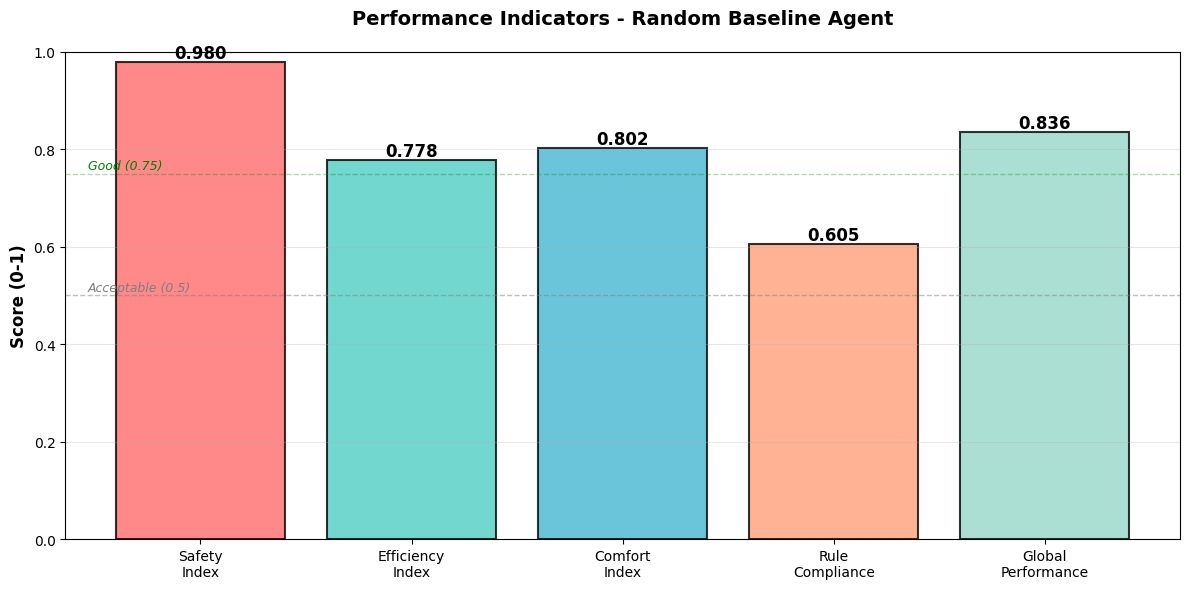


📊 Visualization complete!


In [3]:
# ============================================================================
# VISUALIZATION: Bar Chart of Indicators
# ============================================================================
# Uncomment the code below to create a visual chart

import matplotlib.pyplot as plt

# Prepare data for plotting
indicator_names = ['Safety\nIndex', 'Efficiency\nIndex', 'Comfort\nIndex', 
                   'Rule\nCompliance', 'Global\nPerformance']
indicator_values = [SI, EI, CI, RCI, GPS]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(indicator_names, indicator_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, indicator_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
ax.set_ylim(0, 1.0)
ax.set_ylabel('Score (0-1)', fontsize=12, fontweight='bold')
ax.set_title('Performance Indicators - Random Baseline Agent', fontsize=14, fontweight='bold', pad=20)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.3, linewidth=1)
ax.grid(axis='y', alpha=0.3)

# Add reference lines legend
ax.text(0.02, 0.51, 'Acceptable (0.5)', transform=ax.transAxes, 
        fontsize=9, color='gray', style='italic')
ax.text(0.02, 0.76, 'Good (0.75)', transform=ax.transAxes, 
        fontsize=9, color='green', style='italic')

plt.tight_layout()
plt.show()

print("\n📊 Visualization complete!")

---

## 🏆 PART 4: Multi-Model Comparison

**After running multiple models**, use the cell below to compare them all side-by-side.

This replaces the need for the separate `analyze_results.py` script!

In [4]:
# ============================================================================
# PART 4: Multi-Model Comparison
# ============================================================================
# Run this cell AFTER evaluating all models (DQN, PPO, SAC) to see which wins!
# This automatically loads the most recent results for each model.
# ============================================================================

import glob

# Models to compare
MODELS_TO_COMPARE = [
    ("DQN", "dqn_agent/summary/summary_*.csv"),
    ("PPO", "ppo_agent/summary/summary_*.csv"),
    ("SAC", "sac_agent/summary/summary_*.csv"),
]

print("\n" + "="*70)
print("🏆 MULTI-MODEL COMPARISON")
print("="*70)

comparison_results = []

for model_name, csv_pattern in MODELS_TO_COMPARE:
    csv_files = glob.glob(csv_pattern)
    
    if not csv_files:
        print(f"\n⚠️  No data for {model_name} - train and evaluate it first!")
        continue
    
    # Get most recent results
    latest_csv = max(csv_files, key=os.path.getctime)
    print(f"\n✅ Loading {model_name}: {os.path.basename(latest_csv)}")
    
    # Load and calculate indicators
    model_df = pd.read_csv(latest_csv)
    model_metrics = {}
    for _, row in model_df.iterrows():
        if 'Metric' in model_df.columns and 'Value' in model_df.columns:
            model_metrics[row['Metric']] = row['Value']
        else:
            # Handle old format
            model_metrics = model_df.to_dict('records')[0] if len(model_df) > 0 else {}
            break
    
    # Calculate indicators
    def get_val(metrics, key, default=0.0):
        return metrics.get(key, default)
    
    # Safety Index
    collision_rate = get_val(model_metrics, "collision")
    avg_ttc = get_val(model_metrics, "avg_ttc", -1)
    ttc_violation_rate = get_val(model_metrics, "ttc_violation_rate")
    
    ttc_normalized = min(avg_ttc / 2.0, 1.0) if avg_ttc > 0 else 0.0
    SI = 0.4 * (1 - collision_rate) + 0.4 * ttc_normalized + 0.2 * (1 - ttc_violation_rate)
    
    # Efficiency Index
    avg_speed = get_val(model_metrics, "avg_speed_ms")
    success_rate = get_val(model_metrics, "success")
    speed_ratio = min(avg_speed / 32.0, 1.0)
    EI = 0.5 * speed_ratio + 0.5 * success_rate
    
    # Comfort Index
    jerk = get_val(model_metrics, "avg_jerk")
    lane_changes = get_val(model_metrics, "lane_changes")
    jerk_norm = min(jerk / 10.0, 1.0)
    lane_norm = min(lane_changes / 20.0, 1.0)
    discomfort = 0.6 * jerk_norm + 0.4 * lane_norm
    CI = max(1 - discomfort, 0.0)
    
    # Rule Compliance
    RCI = min(avg_speed / 32.0, 1.0)
    
    # GPS
    GPS = 0.40 * SI + 0.30 * EI + 0.15 * CI + 0.15 * RCI
    
    comparison_results.append({
        'Model': model_name,
        'GPS': GPS,
        'Safety (SI)': SI,
        'Efficiency (EI)': EI,
        'Comfort (CI)': CI,
        'Compliance (RCI)': RCI,
        'Collision Rate': collision_rate,
        'Success Rate': success_rate,
        'Avg Speed': avg_speed,
        'Avg Reward': get_val(model_metrics, "total_reward")
    })

if comparison_results:
    comp_df = pd.DataFrame(comparison_results)
    
    print("\n" + "="*70)
    print("📊 PERFORMANCE INDICATORS COMPARISON")
    print("="*70 + "\n")
    print(comp_df[['Model', 'GPS', 'Safety (SI)', 'Efficiency (EI)', 
                   'Comfort (CI)', 'Compliance (RCI)']].to_string(index=False))
    
    print("\n" + "="*70)
    print("📈 RAW METRICS")
    print("="*70 + "\n")
    print(comp_df[['Model', 'Collision Rate', 'Success Rate', 
                   'Avg Speed', 'Avg Reward']].to_string(index=False))
    
    print("\n" + "="*70)
    print("🥇 WINNERS")
    print("="*70)
    
    best = {
        'Overall (GPS)': comp_df.loc[comp_df['GPS'].idxmax()],
        'Safety': comp_df.loc[comp_df['Safety (SI)'].idxmax()],
        'Efficiency': comp_df.loc[comp_df['Efficiency (EI)'].idxmax()],
        'Comfort': comp_df.loc[comp_df['Comfort (CI)'].idxmax()],
    }
    
    for category, winner in best.items():
        metric = category.split('(')[1].strip(')') if '(' in category else 'GPS'
        score_key = 'GPS' if category == 'Overall (GPS)' else f'{category.split()[0]} ({metric})'
        print(f"   {category:<18}: {winner['Model']:<6} (Score: {winner[score_key]:.4f})")
    
    print("="*70)
    
    # Save comparison
    os.makedirs("model_comparison", exist_ok=True)
    output_path = f"model_comparison/comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    comp_df.to_csv(output_path, index=False)
    print(f"\n💾 Comparison saved: {output_path}")
    
    # Visualization
    try:
        import matplotlib.pyplot as plt
        
        models = comp_df['Model'].tolist()
        x = np.arange(len(models))
        width = 0.15
        
        fig, ax = plt.subplots(figsize=(14, 7))
        
        ax.bar(x - 2*width, comp_df['Safety (SI)'], width, label='Safety', color='#FF6B6B', alpha=0.8)
        ax.bar(x - width, comp_df['Efficiency (EI)'], width, label='Efficiency', color='#4ECDC4', alpha=0.8)
        ax.bar(x, comp_df['Comfort (CI)'], width, label='Comfort', color='#45B7D1', alpha=0.8)
        ax.bar(x + width, comp_df['Compliance (RCI)'], width, label='Compliance', color='#FFA07A', alpha=0.8)
        ax.bar(x + 2*width, comp_df['GPS'], width, label='GPS', color='#98D8C8', alpha=0.8, 
               edgecolor='black', linewidth=2)
        
        ax.set_ylabel('Score (0-1)', fontsize=12, fontweight='bold')
        ax.set_title('Multi-Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(models, fontsize=11)
        ax.legend(loc='upper left', fontsize=10)
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
        ax.axhline(y=0.75, color='green', linestyle='--', alpha=0.3)
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Visualization complete!")
        
    except Exception as e:
        print(f"\n⚠️  Could not create visualization: {e}")

else:
    print("\n❌ No models found. Evaluate at least one model first!")
    print("\n📋 Workflow:")
    print("   1. Change AGENT_TYPE in PART 1 to 'dqn'")
    print("   2. Run PART 1 to evaluate DQN")
    print("   3. Change AGENT_TYPE to 'ppo', run PART 1 again")
    print("   4. Change AGENT_TYPE to 'sac', run PART 1 again")
    print("   5. Run this cell to see comparison!")



🏆 MULTI-MODEL COMPARISON

✅ Loading DQN: summary_20260106_153812.csv

✅ Loading PPO: summary_20260106_154216.csv

✅ Loading SAC: summary_20260106_235829.csv

📊 PERFORMANCE INDICATORS COMPARISON

Model  GPS  Safety (SI)  Efficiency (EI)  Comfort (CI)  Compliance (RCI)
  DQN 0.39          0.6              0.0           1.0               0.0
  PPO 0.39          0.6              0.0           1.0               0.0
  SAC 0.39          0.6              0.0           1.0               0.0

📈 RAW METRICS

Model  Collision Rate  Success Rate  Avg Speed  Avg Reward
  DQN             0.0           0.0        0.0         0.0
  PPO             0.0           0.0        0.0         0.0
  SAC             0.0           0.0        0.0         0.0

🥇 WINNERS
   Overall (GPS)     : DQN    (Score: 0.3900)


KeyError: 'Safety (GPS)'